In [7]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import statsmodels.api as sm
import math

## Read the train, validation and test data with predictions

In [8]:
data_train = pd.read_csv('../data/data_train.csv')
data_val = pd.read_csv('../data/data_val.csv')
data_test = pd.read_csv('../data/data_test.csv')


In [39]:
data_train[['Open', 'High', 'pred_high_open', 'actual_high_open', 'Low', 'pred_low_open', 'actual_low_open',  'Close', ]]

,Open,High,pred_high_open,actual_high_open,Low,pred_low_open,actual_low_open,Close
0,545.760010,550.479980,1.716057,4.719970,542.479980,-1.269214,-3.280030,542.719971
1,540.000000,551.919983,1.718816,11.919983,539.200012,-2.755045,-0.799988,550.559998
2,553.599976,559.200012,1.392747,5.600036,549.440002,-2.925629,-4.159974,558.320007
3,567.119995,585.840027,1.693658,18.720032,566.400024,-5.686240,-0.719971,582.479980
4,571.200012,579.599976,6.318321,8.399964,566.320007,-15.346693,-4.880005,568.080017
...,...,...,...,...,...,...,...,...
2480,76.580002,76.610001,1.662059,0.029999,74.620003,-1.180776,-1.959999,75.419998
2481,77.709999,79.180000,3.730509,1.470001,77.160004,-11.217957,-0.549995,78.989998
2482,78.629997,78.889999,5.934797,0.260002,77.870003,-8.335407,-0.759994,78.389999
2483,79.370003,81.750000,1.047133,2.379997,78.940002,-1.703301,-0.430001,81.680000


## Helper Function: Finding the best delta for any given strategy and data

In [50]:
def plot_best_delta_strategy(data, tune=True, strategy="blind", optimize="sharpe_ratio", delta_percents=np.arange(0, 0.02, 0.0001), verbose=False):

    if tune:
        print(f"Exploring various deltas for the {strategy} strategy....")

        best_sharpe_ratio = None
        best_avg_pnl = None
        best_std_pnl = None
        best_delta_percent = None
        best_pnl = None
        best_profit_days = None
        best_loss_days = None
        best_neutral_days = None
        best_capital = None

        if optimize == "sharpe_ratio":
            best_sharpe_ratio = -1 * float('inf')
        
        elif optimize == "capital":
            best_capital = -1 * float('inf')

        elif optimize == "avg_pnl":
            best_avg_pnl = -1 * float('inf')

        elif optimize == "std_pnl":
            best_std_pnl = -1 * float('inf')

        else:
            print('The optimize parameter should be one of sharpe_ratio, capital, avg_pnl, or std_pnl')
            return


        for delta_percent in delta_percents:
            if strategy == "blind":
                pnl, num_profit_days, num_loss_days, num_neutral_days, capital = blind_strat(data, delta_percent=delta_percent)
            elif strategy == "stoploss":
                pnl, num_profit_days, num_loss_days, num_neutral_days, capital = stoploss_strat(data, delta_percent=delta_percent)
            elif strategy == "long_short":
                pnl, num_profit_days, num_loss_days, num_neutral_days, capital = long_short_strat(data, delta_percent=delta_percent)
            else:
                print('The strategy parameter should be one of blind, stoploss, or long_short.')
                return
        
            avg_pnl = np.mean(pnl)
            std_pnl = np.std(pnl)

            # Assuming a risk-free rate of 0!
            sharpe_ratio = avg_pnl / std_pnl     

            if optimize == 'sharpe_ratio':

                if sharpe_ratio > best_sharpe_ratio:
                    best_sharpe_ratio = sharpe_ratio
                    best_avg_pnl = avg_pnl
                    best_std_pnl = std_pnl
                    best_capital = capital
                    best_delta_percent = delta_percent
                    best_profit_days = num_profit_days
                    best_loss_days = num_loss_days
                    best_neutral_days = num_neutral_days
                    best_pnl = pnl

                if verbose:
                    print(f"""For Delta = {delta_percent*100}% ===> Sharpe Ratio = {sharpe_ratio}""")
                
            if optimize == 'capital':

                if capital > best_capital:
                    best_sharpe_ratio = sharpe_ratio
                    best_avg_pnl = avg_pnl
                    best_std_pnl = std_pnl
                    best_capital = capital
                    best_delta_percent = delta_percent
                    best_profit_days = num_profit_days
                    best_loss_days = num_loss_days
                    best_neutral_days = num_neutral_days
                    best_pnl = pnl

                if verbose:
                    print(f"""For Delta = {delta_percent*100}% ===> Capital = {capital}""")
            
            if optimize == 'avg_pnl':

                if avg_pnl > best_avg_pnl:
                    best_sharpe_ratio = sharpe_ratio
                    best_avg_pnl = avg_pnl
                    best_std_pnl = std_pnl
                    best_capital = capital
                    best_delta_percent = delta_percent
                    best_profit_days = num_profit_days
                    best_loss_days = num_loss_days
                    best_neutral_days = num_neutral_days
                    best_pnl = pnl

                if verbose:
                    print(f"""For Delta = {delta_percent*100}%, ===> Average PNL = {avg_pnl}""")
                
            if optimize == "std_pnl":
                if std_pnl > best_std_pnl:
                    best_sharpe_ratio = sharpe_ratio
                    best_avg_pnl = avg_pnl
                    best_std_pnl = std_pnl
                    best_capital = capital
                    best_delta_percent = delta_percent
                    best_profit_days = num_profit_days
                    best_loss_days = num_loss_days
                    best_neutral_days = num_neutral_days
                    best_pnl = pnl

                if verbose:
                    print(f"""For Delta = {delta_percent*100}% ===> Std PNL = {std_pnl}""")
            
        print()

        print(f"""Best Delta for {strategy} Strategy = {best_delta_percent*100}%,
            ===> Best Sharpe Ratio = {best_sharpe_ratio:3f}
            ===> Sum PnL = {sum(best_pnl):3f}
            ===> Average PNL = {best_avg_pnl:3f}$
            ===> Std PNL = {best_std_pnl:3f}
            ===> Final Capital = {best_capital:3f}$
            ===> Profitable Days = {best_profit_days}
            ===> Lossy Days = {best_loss_days}
            ===> Neutral Days = {best_neutral_days}
            """)

        plt.title(f'P&L Plot for Delta = {best_delta_percent*100}%')
        plt.xlabel('Days')
        plt.ylabel('P&L in U.S. Dollars $')
        plt.plot(best_pnl)

        return best_pnl

    else:
        delta_percent = delta_percents[0]
        if strategy == "blind":
            pnl, num_profit_days, num_loss_days, num_neutral_days, capital = blind_strat(data, delta_percent)  
        elif strategy == "stoploss":
            pnl, num_profit_days, num_loss_days, num_neutral_days, capital = stoploss_strat(data, delta_percent)  
        elif strategy == "long_short":
            pnl, num_profit_days, num_loss_days, num_neutral_days, capital = long_short_strat(data, delta_percent=delta_percent)
        else:
            print('The strategy parameter should be one of blind, stoploss, or long_short.')
            return

        avg_pnl = np.mean(pnl)
        std_pnl = np.std(pnl)

        # Assuming a risk-free rate of 0!
        sharpe_ratio = avg_pnl / std_pnl  

        print(f"""Delta for {strategy} Strategy = {delta_percent*100}%,
        ===> Sharpe Ratio = {sharpe_ratio:3f}
        ===> Sum PnL = {sum(pnl):3f}
        ===> Average PNL = {avg_pnl:3f}$
        ===> Std PNL = {std_pnl:3f}
        ===> Final Capital = {capital:3f}$
        ===> Profitable Days = {num_profit_days}
        ===> Lossy Days = {num_loss_days}
        ===> Neutral Days = {num_neutral_days}
        """)

        plt.title(f'P&L Plot for Delta = {delta_percent*100}%')
        plt.xlabel('Days')
        plt.ylabel('P&L in U.S. Dollars $')
        plt.plot(pnl)

        return pnl

## Strategies

### Blind Strat

In [10]:
def blind_strat(df, delta_percent=0.0001, cap_alloc_limit=0.5, plot_capital=False):
    pnl = []

    capital = 10000

    num_profit_days = 0
    num_loss_days = 0
    num_neutral_days = 0

    capital_list = []

    for day, day_info in df.iterrows():
        # Sell at high else close strat
        predicted_delta = day_info['pred_high_open']
        actual_delta = day_info['actual_high_open']
        open = day_info['Open']
        close = day_info['Close']
        delta = delta_percent * open
        
        # If our prediction is greater than the threshold, trade
        day_return = 0
        
        if predicted_delta >= delta:
            
            # If we hit our high, then sell
            if actual_delta >= predicted_delta:
                day_return = predicted_delta
                # Shares to buy
                num_shares = (capital * cap_alloc_limit) / open
                capital += math.floor(num_shares) * day_return
                
                pnl.append(predicted_delta)
            else:
                # Else, sell at close
                day_return = open-close
                num_shares = (capital * cap_alloc_limit) / open
                capital += math.floor(num_shares) * day_return
                
                pnl.append(open-close)

            if day_return > 0:
                num_profit_days += 1
            elif day_return < 0:
                num_loss_days += 1
            else:
                num_neutral_days += 1

        else:
            pnl.append(0)
            num_neutral_days += 1
        
        capital_list.append(capital)
    
    if plot_capital:
        plt.plot(capital_list)
        plt.title("Capital Over Time")
        plt.xlabel('Days')
        plt.ylabel('Capital in U.S. Dollars $')
        plt.show()
        print("Capital =", capital)


    return pnl, num_profit_days, num_loss_days, num_neutral_days, capital

Exploring various deltas for the blind strategy....

Best Delta for blind Strategy = 0.05%,
            ===> Best Sharpe Ratio = 0.459385
            ===> Sum PnL = 3069.097562
            ===> Average PNL = 1.235049$
            ===> Std PNL = 2.688487
            ===> Final Capital = 9272476.119453$
            ===> Profitable Days = 1910
            ===> Lossy Days = 550
            ===> Neutral Days = 25
            


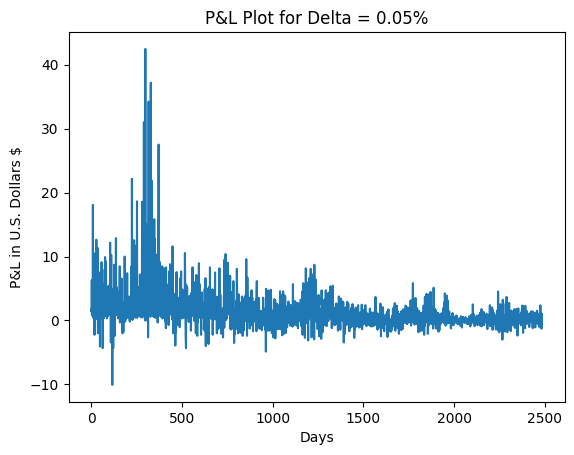

In [51]:
data_train['blind_pnl'] = plot_best_delta_strategy(data=data_train)

Delta for blind Strategy = 0.05%,
        ===> Sharpe Ratio = 0.472127
        ===> Sum PnL = 991.957717
        ===> Average PNL = 1.196571$
        ===> Std PNL = 2.534427
        ===> Final Capital = 81067.272734$
        ===> Profitable Days = 633
        ===> Lossy Days = 189
        ===> Neutral Days = 7
        


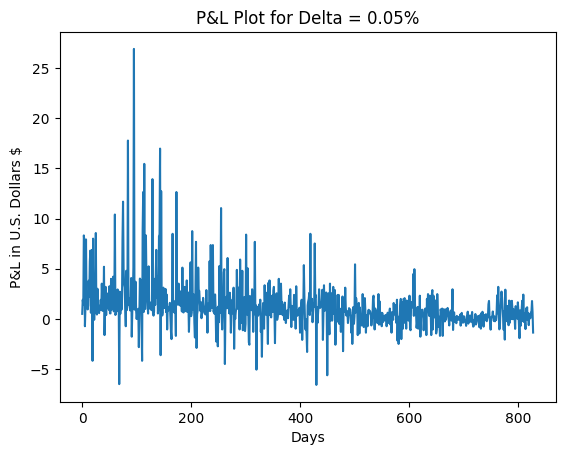

In [52]:
data_val['blind_pnl'] = plot_best_delta_strategy(data=data_val, tune=False, delta_percents=[0.0005])

Delta for blind Strategy = 0.05%,
        ===> Sharpe Ratio = 0.482246
        ===> Sum PnL = 1405.589296
        ===> Average PNL = 1.272027$
        ===> Std PNL = 2.637712
        ===> Final Capital = 194434.585507$
        ===> Profitable Days = 849
        ===> Lossy Days = 246
        ===> Neutral Days = 10
        


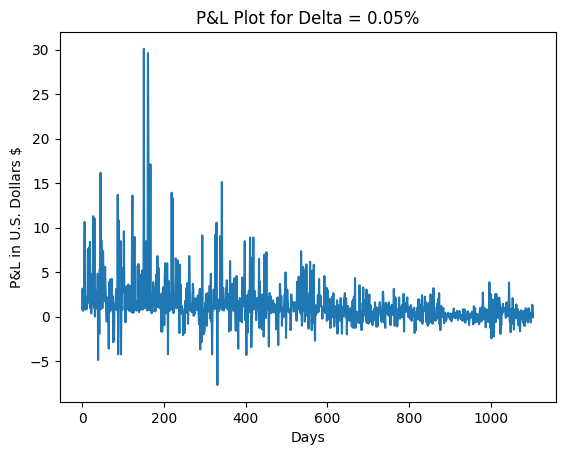

In [53]:
data_test['blind_pnl'] = plot_best_delta_strategy(data=data_test, tune=False, delta_percents=[0.0005])

### Stoploss Strat

In [41]:
def stoploss_strat(df, delta_percent=0.0001, cap_alloc_limit=0.5, plot_capital=False):
    pnl = []

    capital = 10000

    num_profit_days = 0
    num_loss_days = 0
    num_neutral_days = 0
    capital_list = []
    for day, day_info in df.iterrows():
        # Sell at high else close strat
        predicted_delta = day_info['pred_high_open']
        actual_delta = day_info['actual_high_open']
        open = day_info['Open']
        close = day_info['Close']
        delta = delta_percent * open

        # If our prediction is greater than the threshold, trade
        day_return = 0
        
        if predicted_delta >= delta:
            
            # If we hit our high, then sell
            if actual_delta >= predicted_delta:
                day_return = predicted_delta
                # Shares to buy
                num_shares = (capital * cap_alloc_limit) / open
                capital += math.floor(num_shares) * day_return
                
                pnl.append(predicted_delta)
            # Elif Price dips below Open, then sell @ Open
            elif day_info["Low"] < day_info["Open"]:
                day_return = 0
                # Shares to buy
                num_shares = (capital * cap_alloc_limit) / open
                capital += math.floor(num_shares) * day_return
                
                pnl.append(predicted_delta)
            else:
                # Else, sell at close
                day_return = open-close
                num_shares = (capital * cap_alloc_limit) / open
                capital += math.floor(num_shares) * day_return
                
                pnl.append(open-close)

            if day_return > 0:
                num_profit_days += 1
            elif day_return < 0:
                num_loss_days += 1
            else:
                num_neutral_days += 1

        else:
            pnl.append(0)
            num_neutral_days += 1
        
        capital_list.append(capital)
        
    if plot_capital:
        plt.plot(capital_list)
        plt.title("Capital Over Time")
        plt.xlabel('Days')
        plt.ylabel('Capital in U.S. Dollars $')
        plt.show()
        print("Capital =", capital)

    return pnl, num_profit_days, num_loss_days, num_neutral_days, capital

Exploring various deltas for the stoploss strategy....

Best Delta for stoploss Strategy = 0.0%,
            ===> Best Sharpe Ratio = 1.015980
            ===> Sum PnL = 5894.411548
            ===> Average PNL = 2.371997$
            ===> Std PNL = 2.334688
            ===> Final Capital = 264408.849825$
            ===> Profitable Days = 1024
            ===> Lossy Days = 20
            ===> Neutral Days = 1441
            


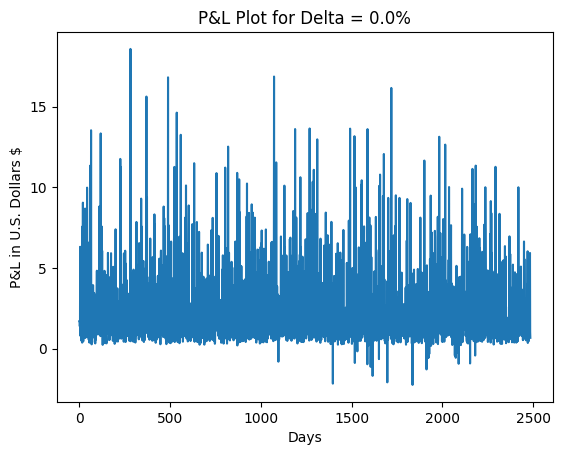

In [54]:
data_train['stoploss_pnl'] = plot_best_delta_strategy(data_train, strategy="stoploss")

Delta for stoploss Strategy = 0%,
        ===> Sharpe Ratio = 0.994109
        ===> Sum PnL = 2080.916315
        ===> Average PNL = 2.510152$
        ===> Std PNL = 2.525027
        ===> Final Capital = 25427.612878$
        ===> Profitable Days = 331
        ===> Lossy Days = 8
        ===> Neutral Days = 490
        


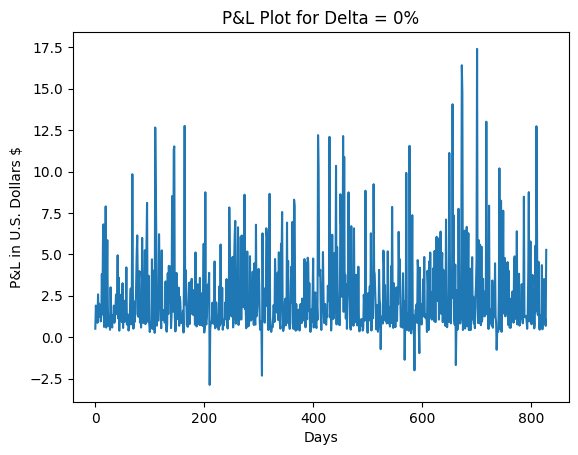

In [55]:
data_val['stoploss_pnl'] = plot_best_delta_strategy(data_val, tune=False, strategy="stoploss", delta_percents=[0])

Delta for stoploss Strategy = 0%,
        ===> Sharpe Ratio = 1.081482
        ===> Sum PnL = 2709.250642
        ===> Average PNL = 2.451811$
        ===> Std PNL = 2.267085
        ===> Final Capital = 42651.814412$
        ===> Profitable Days = 459
        ===> Lossy Days = 11
        ===> Neutral Days = 635
        


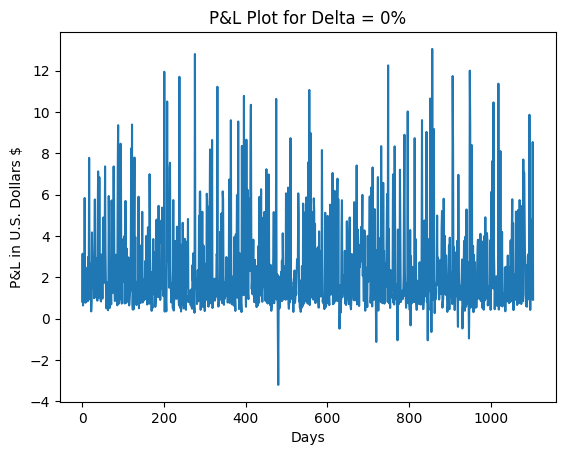

In [56]:
data_test['stoploss_pnl'] = plot_best_delta_strategy(data_test, tune=False, strategy="stoploss", delta_percents=[0])

### Long + Short Strat

In [57]:
def long_short_strat(df, delta_percent=0.0001, cap_alloc_limit=0.5, plot_capital=False):
    pnl = []

    capital = 10000

    num_profit_days = 0
    num_loss_days = 0
    num_neutral_days = 0
    capital_list = []
    for day, day_info in df.iterrows():
        # Sell at high else close strat
        predicted_delta = day_info['pred_high_open']
        actual_delta = day_info['actual_high_open']
        pred_low_delta = day_info["pred_low_open"]
        actual_low_delta = day_info["actual_low_open"]

        open = day_info['Open']
        close = day_info['Close']
        delta = delta_percent * open

        # If our prediction is greater than the threshold, trade
        day_return = 0
        day_return_short = 0
        
        # Long Trade
        if predicted_delta >= delta:
            
            # If we hit our high, then sell
            if actual_delta >= predicted_delta:
                day_return = predicted_delta
                # Shares to buy
                num_shares = (capital * cap_alloc_limit) / open
                capital += math.floor(num_shares) * day_return
                
                pnl.append(predicted_delta)
            else:
                # Else, sell at close
                day_return = open-close
                num_shares = (capital * cap_alloc_limit) / open
                capital += math.floor(num_shares) * day_return
                
                pnl.append(open-close)
        else:
            pnl.append(0)
            num_neutral_days += 1

        if pred_low_delta <= delta:
            if actual_low_delta <= pred_low_delta:
                day_return_short = pred_low_delta * -1
                num_shares = (capital * (1-cap_alloc_limit)) / open
                capital += math.floor(num_shares) * day_return_short
                pnl[-1] += pred_low_delta * -1
            else:
                day_return_short = (open-close) * -1
                num_shares = (capital * (1-cap_alloc_limit)) / open
                capital += math.floor(num_shares) * day_return_short
                pnl[-1] += pred_low_delta * -1

        # if day_return > 0 and day_return_short > 0:
            # print(f"Long Profit : {day_return} and Short Profit : {day_return_short}")


        if day_return + day_return_short > 0:
            num_profit_days += 1
        elif day_return + day_return_short < 0:
            num_loss_days += 1
        else:
            num_neutral_days += 1
        capital_list.append(capital)

    if plot_capital:    
        plt.plot(capital_list)
        plt.title("Capital Over Time")
        plt.xlabel('Days')
        plt.ylabel('Capital in U.S. Dollars $')
        plt.show()
        print("Capital =", capital)
    return pnl, num_profit_days, num_loss_days, num_neutral_days, capital

Exploring various deltas for the long_short strategy....

Best Delta for long_short Strategy = 0.05%,
            ===> Best Sharpe Ratio = 0.927348
            ===> Sum PnL = 9815.572933
            ===> Average PNL = 3.949929$
            ===> Std PNL = 4.259380
            ===> Final Capital = 11498674013.490738$
            ===> Profitable Days = 1511
            ===> Lossy Days = 7
            ===> Neutral Days = 969
            


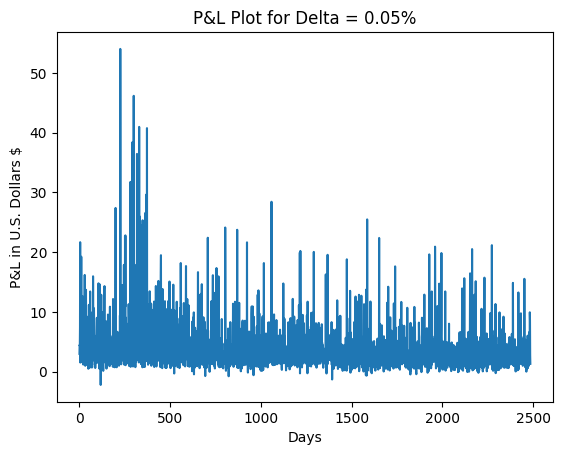

In [58]:
data_train['long_short_pnl'] = plot_best_delta_strategy(data=data_train, strategy="long_short")

Delta for long_short Strategy = 0.05%,
        ===> Sharpe Ratio = 1.077350
        ===> Sum PnL = 3379.032046
        ===> Average PNL = 4.076034$
        ===> Std PNL = 3.783390
        ===> Final Capital = 1010053.446476$
        ===> Profitable Days = 506
        ===> Lossy Days = 2
        ===> Neutral Days = 323
        


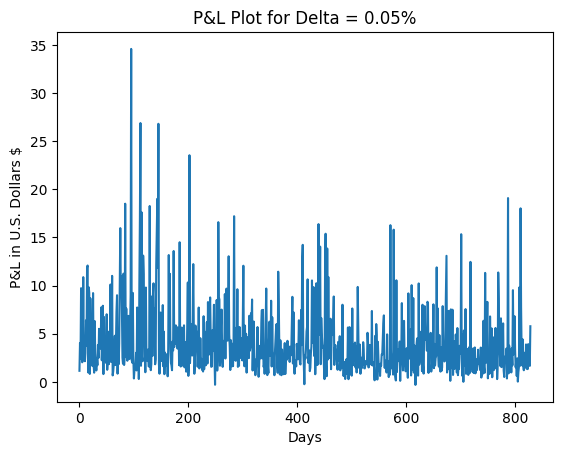

In [59]:
data_val['long_short_pnl'] = plot_best_delta_strategy(data=data_val, tune=False, strategy="long_short", delta_percents=[0.0005])

Delta for long_short Strategy = 0.05%,
        ===> Sharpe Ratio = 1.066784
        ===> Sum PnL = 4498.802807
        ===> Average PNL = 4.071315$
        ===> Std PNL = 3.816438
        ===> Final Capital = 4403325.338273$
        ===> Profitable Days = 660
        ===> Lossy Days = 0
        ===> Neutral Days = 445
        


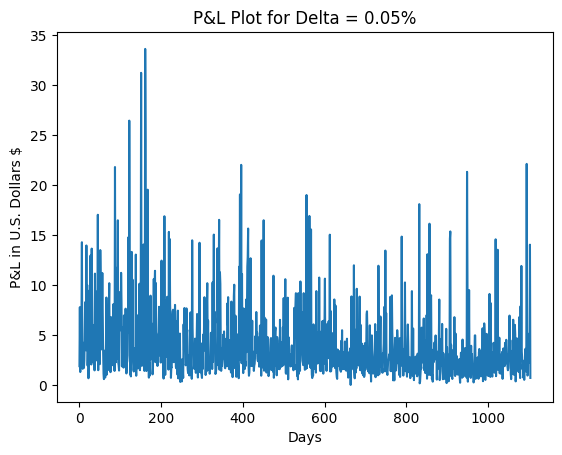

In [60]:
data_test['long_short_pnl'] = plot_best_delta_strategy(data=data_test, tune=False, strategy="long_short", delta_percents=[0.0005])

## Benchmarking and Sanity Checks

In [61]:
data_val["max_profit"] = data_val["High"] - data_val["Low"]
data_test["max_profit"] = data_test["High"] - data_test["Low"]

In [67]:
print('Blind strategy')
print('Validation data:')
print(data_val['max_profit'].describe())
print()
print(data_val['blind_pnl'].describe())
print()
print('Test data:')
print(data_test['max_profit'].describe())
print()
print(data_test['blind_pnl'].describe())


Blind strategy
Validation data:
count    829.000000
mean       5.402726
std        6.030417
min        0.329998
25%        1.700004
50%        3.440002
75%        6.559998
max       45.759994
Name: max_profit, dtype: float64

count    829.000000
mean       1.196571
std        2.535957
min       -6.559998
25%        0.080002
50%        0.781060
75%        1.760010
max       26.880005
Name: blind_pnl, dtype: float64

Test data:
count    1105.000000
mean        5.240941
std         5.758783
min         0.250000
25%         1.679993
50%         3.209999
75%         6.640014
max        45.440002
Name: max_profit, dtype: float64

count    1105.000000
mean        1.272027
std         2.638906
min        -7.679992
25%         0.089998
50%         0.811199
75%         1.702703
max        30.080017
Name: blind_pnl, dtype: float64


In [68]:
print('Stoploss strategy')
print('Validation data:')
print(data_val['max_profit'].describe())
print()
print(data_val['stoploss_pnl'].describe())
print()

print('Test data:')
print(data_test['max_profit'].describe())
print()
print(data_test['stoploss_pnl'].describe())


Stoploss strategy
Validation data:
count    829.000000
mean       5.402726
std        6.030417
min        0.329998
25%        1.700004
50%        3.440002
75%        6.559998
max       45.759994
Name: max_profit, dtype: float64

count    829.000000
mean       2.510152
std        2.526551
min       -2.880005
25%        0.865761
50%        1.561083
75%        3.280466
max       17.400164
Name: stoploss_pnl, dtype: float64

Test data:
count    1105.000000
mean        5.240941
std         5.758783
min         0.250000
25%         1.679993
50%         3.209999
75%         6.640014
max        45.440002
Name: max_profit, dtype: float64

count    1105.000000
mean        2.451811
std         2.268111
min        -3.200012
25%         0.925297
50%         1.589918
75%         3.279388
max        13.057285
Name: stoploss_pnl, dtype: float64


In [69]:
print('Long Short strategy')
print('Validation data:')
print(data_val['max_profit'].describe())
print()
print(data_val['long_short_pnl'].describe())
print()

print('Test data:')
print(data_test['max_profit'].describe())
print()
print(data_test['long_short_pnl'].describe())

Long Short strategy
Validation data:
count    829.000000
mean       5.402726
std        6.030417
min        0.329998
25%        1.700004
50%        3.440002
75%        6.559998
max       45.759994
Name: max_profit, dtype: float64

count    829.000000
mean       4.076034
std        3.785674
min       -0.321138
25%        1.679855
50%        2.873628
75%        5.183254
max       34.592498
Name: long_short_pnl, dtype: float64

Test data:
count    1105.000000
mean        5.240941
std         5.758783
min         0.250000
25%         1.679993
50%         3.209999
75%         6.640014
max        45.440002
Name: max_profit, dtype: float64

count    1105.000000
mean        4.071315
std         3.818166
min         0.009822
25%         1.627892
50%         2.786486
75%         5.144974
max        33.636229
Name: long_short_pnl, dtype: float64


In [70]:
data_train.to_csv('../data/data_train.csv')
data_val.to_csv('../data/data_val.csv')
data_test.to_csv('../data/data_test.csv')